In [1]:
from utils.experiment_utils import get_all_experiments_info, load_best_model
import torch
import os
import hydra
from omegaconf import DictConfig, OmegaConf

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

from tqdm.notebook import tqdm

from datasets.distribution_datasets import MultivariateNormalDistributionDataset

import scipy as sp

import matplotlib.patches as patches

In [2]:
device = 'cuda'
configs = get_all_experiments_info('/orcd/data/omarabu/001/gokul/DistributionEmbeddings/outputs/', False)
cfg = [c for c in configs if 'mvn_sys' in c['name']]
print(len(cfg))

# load model and move to device
def load_model(cfg, path, device):
    enc = hydra.utils.instantiate(cfg['encoder'])
    gen = hydra.utils.instantiate(cfg['generator'])
    state = load_best_model(path)
    enc.load_state_dict(state['encoder_state_dict'])
    gen.model.load_state_dict(state['generator_state_dict'])
    enc.eval()
    gen.eval()
    enc.to(device)
    gen.to(device)
    return enc, gen

150


In [ ]:
def wasserstein_zip(mu1, mu2, cov1, cov2):
    mean_dist = np.linalg.norm(mu1 - mu2, axis=1)
    var_dist = np.zeros(len(mu1))
    for i, (c1, c2) in enumerate(zip(cov1, cov2)):
        sqrt_c1 = sp.linalg.sqrtm(c1)
        prod = sqrt_c1 @ c2 @ sqrt_c1
        var_dist[i] = np.trace(c1 + c2 - 2 * sp.linalg.sqrtm(prod))
    return mean_dist + var_dist  # (n,)


def batch_cov(x):
    # x: (b, n, d)
    x = x - x.mean(dim=1, keepdim=True)     # center!
    cov = x.transpose(1, 2) @ x / (x.shape[1] - 1)  # sample cov :)
    return cov  # (b, d, d)

In [4]:
n_sets = 200

bs = 8

d = {
    "Encoder" : [],
    "Generator" : [],
    "N dims" : [],
    "OT reconstruction error" : [],
    'Parameter MSE' : []
}

for c in tqdm(cfg):
    encoder_name = c['encoder']
    generator_name = c['generator']

    if generator_name == 'DirectGenerator':
        generator_name += '-'+c['config']['generator']['loss_type']
        if 'mmd' in generator_name:
            continue
    
    # if encoder_name not in ['MeanEncoder', 'DistributionEncoderGNN']:
    #     continue
    # if generator_name != 'DDPM':
    #     continue
        
    data_shape = c['config']['dataset']['data_shape']
    print(encoder_name, generator_name, data_shape)
    try:
        enc, gen = load_model(c['config'], c['dir'], device=device)
    except:
        print("broken: ", encoder_name)
        continue

    if 'Tx' not in encoder_name and 'Wormhole' not in encoder_name:
        set_size = 10**4
    else:
        set_size=10**3

    # load dataset
    dataset = MultivariateNormalDistributionDataset(set_size=set_size,
                                                    n_sets=n_sets,
                                                    data_shape=data_shape,
                                                    prior_cov_scale = c['config']['dataset']['prior_cov_scale'],
                                                           )
    # dataset = hydra.utils.instantiate(c['config']['dataset'])
    
    mus = dataset.mu # shape: batch, d
    covs = dataset.cov # shape: batch, d, d


    rec_error = []
    mses = []
    for idx in range(len(dataset)//bs):

        with torch.no_grad():
            x = torch.tensor(dataset.data[idx*bs:(idx+1)*bs], dtype=torch.float).cuda()
            z = enc(x)
            x_hat = gen.sample(z, num_samples=set_size)

        r_mus = x_hat.mean(axis=1).cpu().numpy()
        r_covs = batch_cov(x_hat).cpu().numpy()

        m = x.mean(axis=1).cpu().numpy()
        c = batch_cov(x).cpu().numpy()

        mu_mse = np.mean(np.linalg.norm(m - r_mus, axis=1))
        cov_mse = np.mean(np.linalg.norm(c - r_covs, axis=(1, 2)))


        rec_error.append(wasserstein_zip(m, r_mus, c, r_covs))
        mses.append(mu_mse + cov_mse)


        # fig = plt.figure(figsize=(2,2))
        # sns.scatterplot(x=c.flatten(), y=r_covs.flatten(), color='blue', alpha=0.5)
        # plt.xlabel('sample cov')
        # plt.ylabel('generated sample cov')
        # plt.show()

        # fig = plt.figure(figsize=(2,2))
        # sns.heatmap(data=c[0], square=True)
        # plt.show()

        # fig = plt.figure(figsize=(2,2))
        # sns.heatmap(data=r_covs[0], square=True)
        # plt.show()

        # break



    
    d["Encoder"].append(encoder_name)
    d["Generator"].append(generator_name)
    d["N dims"].append(data_shape[0])
    d["OT reconstruction error"].append(np.mean(rec_error))
    d['Parameter MSE'].append(np.mean(mses))


  0%|          | 0/150 [00:00<?, ?it/s]

DistributionEncoderTx DirectGenerator-swd [5]
[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
KMEEncoder CVAE [5]
DistributionEncoderTx DirectGenerator-swd [5]
DistributionEncoderMedianGNN DirectGenerator-swd [5]
KMEEncoder CVAE [5]
DistributionEncoderGNN DirectGenerator-sinkhorn [5]
DistributionEncoderTx DDPM [5]
DistributionEncoderResNet DDPM [5]
MeanEncoder DirectGenerator-sinkhorn [5]
DistributionEncoderMedianGNN DirectGenerator-sinkhorn [5]
DistributionEncoderMedianGNN DDPM [5]
DistributionEncoderTx DirectGenerator-sinkhorn [5]
MeanEncoder DirectGenerator-swd [5]
DistributionEncoderResNet DDPM [5]
MeanEncoder CVAE [5]0
DistributionEncoderGNN WormholeGenerator [5]
MeanEncoder WormholeGenerator [5]
DistributionEncoderResNet DirectGenerator-sinkhorn [5]
DistributionEncoderMedianGNN DirectGenerator-sinkhorn [5]
KMEEncoder CVAE [5]
MeanEncoder DDPM [5]
DistributionEncoderResNet DirectGenerator-sinkhorn [5]
MeanEncoder WormholeGenerator [5]
KMEE

In [5]:
pd.DataFrame(d).sort_values('OT reconstruction error')

,Encoder,Generator,N dims,OT reconstruction error,Parameter MSE
79,DistributionEncoderMedianGNN,DDPM,5,0.085112,0.181092
78,MeanEncoder,CVAE,5,0.085211,0.294541
13,DistributionEncoderResNet,DDPM,5,0.087170,0.203048
24,MeanEncoder,CVAE,5,0.087681,0.301565
103,DistributionEncoderResNet,DDPM,5,0.088009,0.216120
...,...,...,...,...,...
90,DistributionEncoderMedianGNN,WormholeGenerator,5,0.852724,1.096037
28,DistributionEncoderGNN,WormholeGenerator,5,0.859523,1.108167
126,DistributionEncoderMedianGNN,WormholeGenerator,5,0.892252,1.141130
91,DistributionEncoderGNN,WormholeGenerator,5,0.897820,1.143848


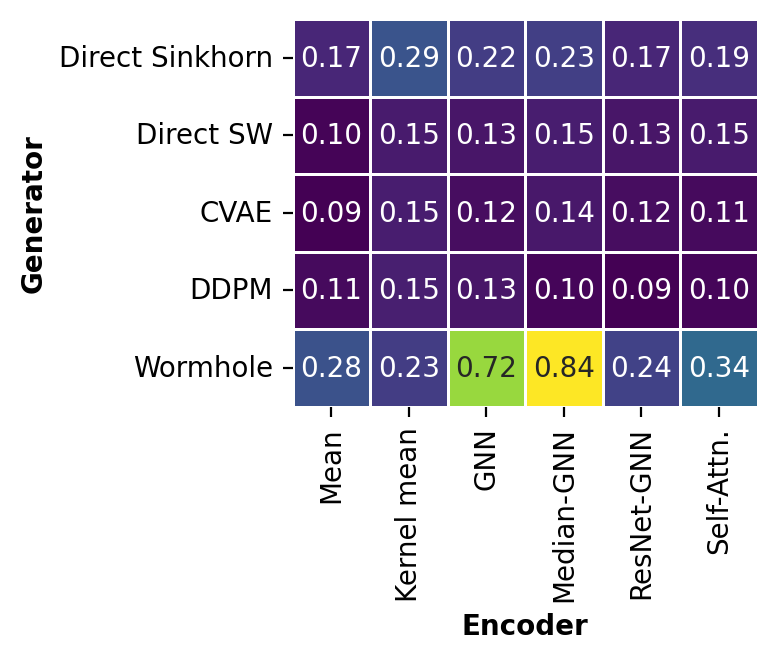

In [6]:
df = pd.DataFrame(d)

df.replace("DistributionEncoderGNN", "GNN", inplace=True)
df.replace("DistributionEncoderMedianGNN", "Median-GNN", inplace=True)
df.replace("DistributionEncoderResNet", "ResNet-GNN", inplace=True)
df.replace("MeanEncoder", "Mean", inplace=True)
df.replace('DistributionEncoderTx', 'Self-Attn.', inplace=True)
df.replace('WormholeEncoder', 'Self-Attn.', inplace=True)
df.replace('DirectGenerator-sinkhorn', 'Direct Sinkhorn', inplace=True)
df.replace('DirectGenerator-swd', 'Direct SW', inplace=True)
df.replace('WormholeGenerator', 'Wormhole', inplace=True)
df.replace('KMEEncoder', 'Kernel mean', inplace=True)

plt.figure(figsize=(3, 3), dpi=200)

row_order = ['Direct Sinkhorn', 'Direct SW', 'CVAE', 'DDPM', 'Wormhole']
column_order = ['Mean', 'Kernel mean', 'GNN', 'Median-GNN', 'ResNet-GNN', 'Self-Attn.']

table = df.pivot_table(columns='Encoder', index='Generator', 
                           values='OT reconstruction error', aggfunc='mean').reindex(index=row_order, columns=column_order) 

heatmap = sns.heatmap(table, 
            annot=True, fmt=".2f", cmap="viridis", 
            square=True, lw=0.5,
            cbar=False)

# Highlight the cell at row 4, column 5
row_idx = 3  # Zero-based index for the 5th row
col_idx = 4  # Zero-based index for the 6th column

# Get the position of the cell
x = col_idx
y = row_idx

# Add a rectangle to highlight the cell
# ax = heatmap.axes
# rect = patches.Rectangle((x, y), 1, 1, linewidth=3, edgecolor='aqua', linestyle='solid', facecolor='none')
# ax.add_patch(rect)

# rect = patches.Rectangle((x, 0.05), 1, 4.9, linewidth=1, edgecolor='green', linestyle='dashed', facecolor='none')
# ax.add_patch(rect)

# rect = patches.Rectangle((0.05, y), 5.9, 1, linewidth=1, edgecolor='green', linestyle='dashed', facecolor='none')
# ax.add_patch(rect)

# plt.xticks(rotation=60)
plt.xlabel('Encoder', fontweight='bold')
plt.ylabel('Generator', fontweight='bold')
# plt.xlabel('')
# plt.ylabel('')
# plt.text(-2, 0, 'Encoder', fontweight='bold', fontsize=12)
# plt.text(-0.25, 7.5, 'Generator', fontweight='bold', fontsize=12, rotation=90)


# plt.tight_layout()
plt.show()

In [7]:
grouped = df.groupby(['Encoder', 'Generator', 'N dims'])['OT reconstruction error'].agg(['mean', 'sem']).reset_index()

grouped.rename(columns={'mean': 'OT reconstruction error mean',
                        'sem': 'OT reconstruction error SEM'}, inplace=True)

print(grouped)

        Encoder        Generator  N dims  OT reconstruction error mean  \
0           GNN             CVAE       5                      0.117049   
1           GNN             DDPM       5                      0.134556   
2           GNN        Direct SW       5                      0.134179   
3           GNN  Direct Sinkhorn       5                      0.224288   
4           GNN         Wormhole       5                      0.724086   
5   Kernel mean             CVAE       5                      0.152425   
6   Kernel mean             DDPM       5                      0.154259   
7   Kernel mean        Direct SW       5                      0.147611   
8   Kernel mean  Direct Sinkhorn       5                      0.285991   
9   Kernel mean         Wormhole       5                      0.226549   
10         Mean             CVAE       5                      0.092383   
11         Mean             DDPM       5                      0.112742   
12         Mean        Direct SW      

In [8]:
# table.to_csv('numerical_results/benchmark_mvn.csv')